### CPU 환경

In [1]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              64
On-line CPU(s) list: 0-63
Thread(s) per core:  2
Core(s) per socket:  16
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz
Stepping:            7
CPU MHz:             800.239
CPU max MHz:         3200.0000
CPU min MHz:         800.0000
BogoMIPS:            4200.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            22528K
NUMA node0 CPU(s):   0-15,32-47
NUMA node1 CPU(s):   16-31,48-63
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq

### GPU 환경

In [2]:
!nvidia-smi

Mon Mar 15 00:39:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:3B:00.0 Off |                  N/A |
|  0%   33C    P0   102W / 350W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   

### RAM 용량 확인

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           376G        1.4G         28G        2.4M        346G        372G
Swap:          8.0G        1.5M        8.0G


### HDD 용량 확인

In [4]:
# 디스크 용량 확인
!df -h

Filesystem                         Size  Used Avail Use% Mounted on
udev                               189G     0  189G   0% /dev
tmpfs                               38G  2.5M   38G   1% /run
/dev/mapper/ubuntu--vg-ubuntu--lv  915G  287G  589G  33% /
tmpfs                              189G     0  189G   0% /dev/shm
tmpfs                              5.0M     0  5.0M   0% /run/lock
tmpfs                              189G     0  189G   0% /sys/fs/cgroup
/dev/sda                           916G  660G  210G  76% /data
/dev/nvme0n1p2                     976M  195M  715M  22% /boot
/dev/nvme0n1p1                     511M  6.1M  505M   2% /boot/efi
tmpfs                               38G     0   38G   0% /run/user/1000
tmpfs                               38G     0   38G   0% /run/user/1006


### OS 환경

In [5]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


## 패키지 설치

In [6]:
#!pip install numpy

# Pytorch 10.2 GPU install
#!pip install torch

# Pytorch 10.2 CPU install
#!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

#!pip install torchvision
#!pip install torchinfo
#!pip install tqdm

## 패키지 불러오기

In [8]:
import sys, time, datetime, pytz
import numpy as np

import torch, torchvision
import torch.nn as nn

from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets

from Model import UNet
from Dataset import Dataset, Normalization, ToTensor
from Utils import IOU_Numpy, Draw_Image

from torchinfo import summary

from tqdm import tqdm

## 설치 패키지 확인

In [9]:
print('python version:',sys.version)
print('numpy version:', np.__version__)
print('torch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

python version: 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
numpy version: 1.19.2
torch version: 1.7.1
torchvision version: 0.8.2


## 모델 파라미터 (Parameter)

In [10]:
# 모델에 입력할 Input 이미지의 크기를 지정함.
IMG_WIDTH = 512
IMG_HEIGHT = 512

# 각 Input당 결과를 확인하기 위하여 배치 사이즈를 1로 지정함.
batch_size = 1

# 데이터를 읽어올 경로를 지정함.
side_data_dir = "../Dataset/preprocessed/segmentation/side_result/"
top_data_dir = "../Dataset/preprocessed/segmentation/top_result/"
# 학습된 모델이 저장된 경로를 지정함.
ckpt_dir = "./Models/"
# 생성된 이미지를 저장하는 경로를 지정함.
save_dir = "./Images_Results/"

# 모델 이름
Model_name = "egg_segmentation"
# 모델을 연산할 장비 설정 (Docker환경에서 작동할 수 있도록 CPU에서 계산함)
device = torch.device('cpu')

## 데이터 셋 확인

In [11]:
# Test 데이터를 읽어옴
test_top_dataset_temp = Dataset(data_dir=top_data_dir, train=False)
n_top_test = len(test_top_dataset_temp)
test_side_dataset_temp = Dataset(data_dir=side_data_dir, train=False)
n_side_test = len(test_side_dataset_temp)

# transform 적용해서 Train 데이터 셋 불러오기
train_top_dataset_temp = Dataset(data_dir=top_data_dir, train=True)
n_top_train = len(train_top_dataset_temp)
train_side_dataset_temp = Dataset(data_dir=side_data_dir, train=True)
n_side_train = len(train_side_dataset_temp)

# Train 개수를 Test 갯수만큼 Train와 Vlidation set으루 나눔
train_top_ds, valid_top_ds = torch.utils.data.random_split(train_top_dataset_temp, [int(n_top_train - n_top_test), n_top_test])
train_side_ds, valid_side_ds = torch.utils.data.random_split(train_side_dataset_temp, [int(n_side_train - n_side_test), n_side_test])

# Top과 Side 데이터들을 Concatenation 시킴
train_ds = ConcatDataset([train_top_ds, train_side_ds])
valid_ds = ConcatDataset([valid_top_ds, valid_side_ds])

print("The Number of Each Set")
print('Train set: %d, Validation set: %d, Test set: %d' %(len(train_ds), len(valid_ds), n_top_test+n_side_test))

The Number of Each Set
Train set: 23204, Validation set: 2908, Test set: 2908


## 데이터 셋 (Dataset) 불러오기

In [12]:
test_transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

# Test
test_top_dataset = Dataset(data_dir=side_data_dir, train=False, transform=test_transform)
test_side_dataset = Dataset(data_dir=top_data_dir, train=False, transform=test_transform)

# Concat
test_dataset = ConcatDataset([test_top_dataset, test_side_dataset])

# Test loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)
print(f'Test set size: {len(test_dataset)}')

Test set size: 2908


## 모델 확인 (Summary)

In [13]:
temp_model = UNet()
_ = summary(temp_model, (batch_size, 3, IMG_WIDTH, IMG_HEIGHT))

## 테스트 (Test) 수행

In [14]:
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

### 모델 불러오기 (Load)

In [15]:
# 모델의 구조를 불러옴.
eval_net = UNet().to(device) # device : cpu
# 학습된 가중치를 읽어옴.
state_dict = torch.load(ckpt_dir + Model_name + ".pkl", map_location=device)
## nn.DataParallel을 통해 학습을 시켰다면, 모델에 자동적으로 module.를 붙이게 된다
# 따라서 다음의 코드를 통해 module.를 제거함.
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
## nn.DataParallel을 통해 학습을 시켰다면 new_state_dict, 아니면 state_dict를 불러올 것
eval_net.load_state_dict(new_state_dict)

<All keys matched successfully>

### 테스트 이미지 평가 (Predict)

In [16]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 시작 시간 : {nowDatetime}')

테스트 시작 시간 : 2021-03-15 09:40:48


In [17]:
since=time.time()

In [18]:
with torch.no_grad():  # test 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
    eval_net.eval()  # 네트워크를 evaluation 용으로 선언
    test_iou_arr = []
    
    for data in tqdm(test_loader):
        # forward
        label = data['label'].to(device)
        inputs = data['input'].to(device)
        output = eval_net(inputs)

        # loss
        test_iou_arr += [IOU_Numpy(fn_classifier(output), label)]
    
    test_iou_np = np.array(test_iou_arr)
    
    print("threshold (0.5): mean %.4f | std %.4f, | max %.4f, | min %.4f" % (np.mean(test_iou_np), np.std(test_iou_np), np.max(test_iou_np), np.min(test_iou_np)))  

100%|██████████| 2908/2908 [50:22<00:00,  1.04s/it]

threshold (0.5): mean 0.9163 | std 0.0483, | max 0.9862, | min 0.5369


In [19]:
end=time.time()
print(f'테스트 소요 시간: {int((end-since)//60)}m {int((end-since)%60)}s')

테스트 소요 시간: 60m 1s


In [20]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 종료 시간 : {nowDatetime}')

테스트 종료 시간 : 2021-03-15 10:40:54


## 시각화 (VIsualization)

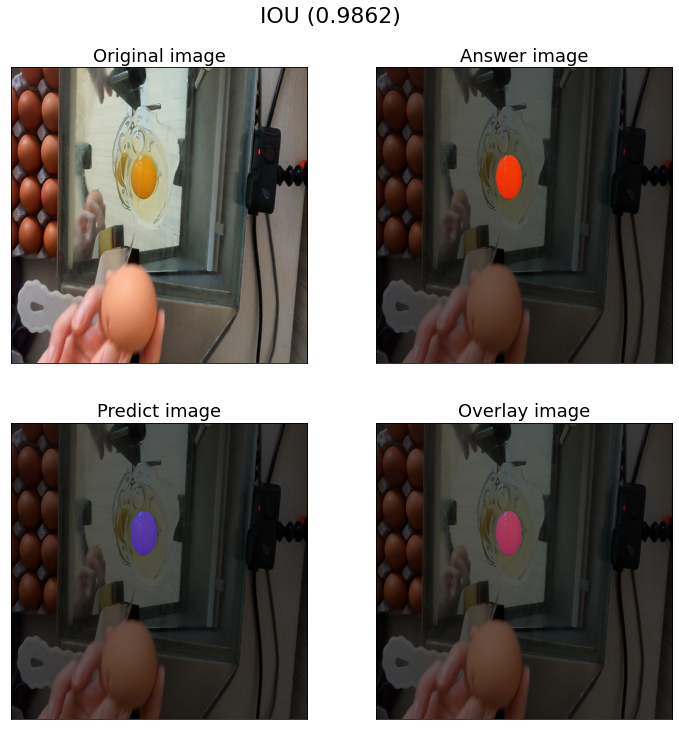

In [21]:
# IOU가 가장 좋은 결과
Draw_Image(eval_net, test_dataset, test_iou_np, save_dir, Model_name, idx=0, device=device)

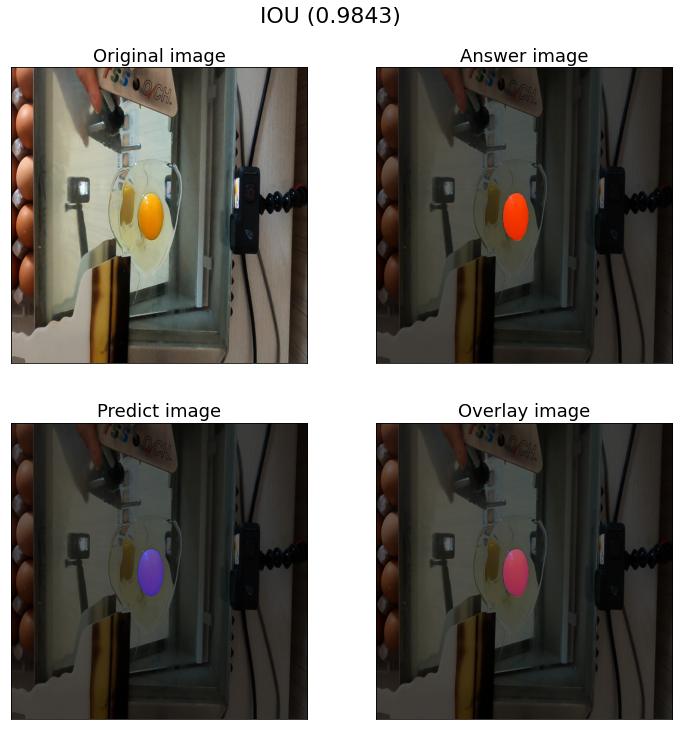

In [22]:
# IOU가 두번째로 좋은 결과
Draw_Image(eval_net, test_dataset, test_iou_np, save_dir, Model_name, idx=1, device=device)

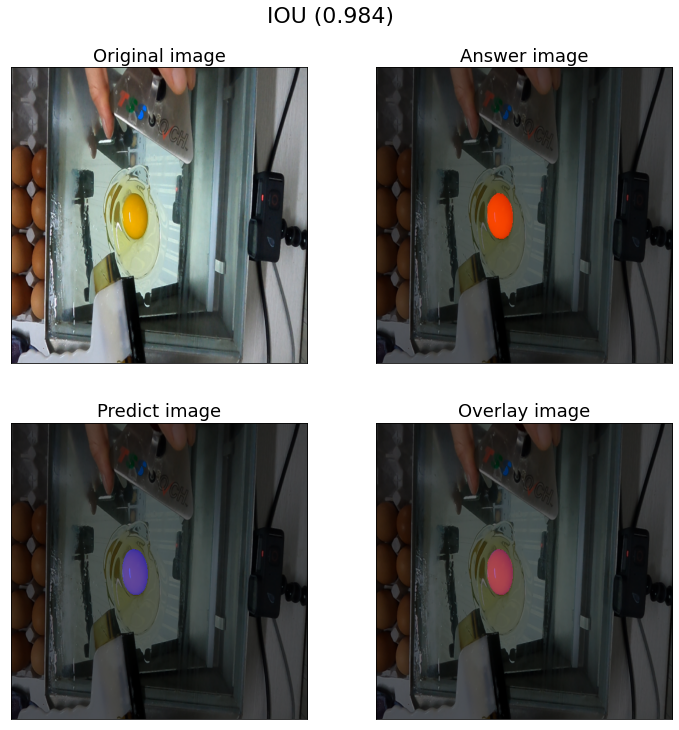

In [24]:
# IOU가 세번째로 좋은 결과
Draw_Image(eval_net, test_dataset, test_iou_np, save_dir, Model_name, idx=2, device=device)